# Composite fiber materials (Kia 02032022)
Overfitting happens with few samples we have. 

Prediction of:
1) glass temperature (Tg) 

In [1]:
# Import Python libaries
%matplotlib inline
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

# Doing some chemistry and feature engineering of the structure
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

from chainer_chemistry.datasets.molnet import get_molnet_dataset

In [2]:
# reading .csv file
file_name = 'VO_RD_Composites.csv'
dataset = pd.read_csv(file_name)
# save the columns' names in a list
col_list = list (dataset.columns.values.tolist())

In [3]:
# drop rows with Nan values 
dataset_drop_Tg_NAs = dataset.dropna(subset=['Tg'])
dataset_drop_TgTs_NAs =  dataset.dropna(subset=['Tg', 'Tensile strength (MPa)'])
dataset_drop_NAs = dataset.dropna()


num_NAs = dataset.isnull().sum()
dataset.isnull()
print ("Original # samples: {}\nSamples with missing values: \n{}\nTotal {} missing\n\
Left: {}".\
       format(len(dataset.index), num_NAs, num_NAs.sum(),len(dataset_drop_NAs.index)))

Original # samples: 47
Samples with missing values: 
Matrix                      0
Matrix_SMILES               0
C chain of matrix           0
Unsaturation of matrix      0
Reactive diluents(RD)       0
RD_SMILES                   0
Molecule Weight of RD       0
Unsaturation of RD          0
Number of benzene of RD     0
Miscibility of RD           0
ester group of RD           0
viscosity of resin(mp.s)    6
weight_ratioM_R             0
Matrix_ratio                0
RD_ratio                    0
Fibers                      0
Tensile strength (MPa)      4
Flexure strength (MPa)      0
Tg                          4
dtype: int64
Total 14 missing
Left: 33


In [4]:
# drop a row that has NO MWRD
index_NO_MWRD = dataset_drop_TgTs_NAs.loc[dataset_drop_TgTs_NAs['Molecule Weight of RD']=='NO'].index.to_numpy()[0]
dataset_drop_TgTs_NAs = dataset_drop_TgTs_NAs.drop(index=index_NO_MWRD)

In [5]:
Tg = np.array (dataset_drop_TgTs_NAs['Tg'])
Ts = np.array (dataset_drop_TgTs_NAs['Tensile strength (MPa)'])
MW_RD = np.array (dataset_drop_TgTs_NAs['Molecule Weight of RD'].astype(float))
Unsat_RD = np.array (dataset_drop_TgTs_NAs['Unsaturation of RD'].astype(float))
Matrix_SMILES = np.array (dataset_drop_TgTs_NAs['Matrix_SMILES'])
RD_SMILES = np.array (dataset_drop_TgTs_NAs['RD_SMILES'])
Mat_ratio = dataset_drop_TgTs_NAs['Matrix_ratio']
RD_ratio = dataset_drop_TgTs_NAs['RD_ratio']

num_sam = Tg.shape[0]
RD_SMILES.shape

(38,)

Text(0.5, 1.0, 'Hist. of Tg')

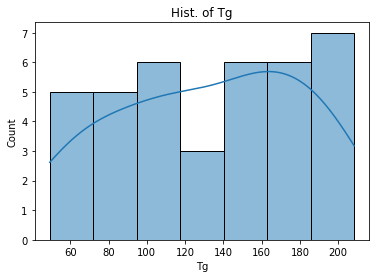

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=Tg, kde=True)
plt.xlabel('Tg')
plt.title('Hist. of Tg')

In [7]:
features = {
    'MolWt': Descriptors.MolWt,
    'HeavyAtomCount': Descriptors.HeavyAtomCount,
    'HeavyAtomMolWt': Descriptors.HeavyAtomMolWt,
    'NumHAcceptors': Descriptors.NumHAcceptors,
    'NumHDonors': Descriptors.NumHDonors,
    'NumHeteroatoms': Descriptors.NumHeteroatoms,
    'NumRotatableBonds': Descriptors.NumRotatableBonds,
    'NumValenceElectrons': Descriptors.NumValenceElectrons,
    'NumAromaticRings': Descriptors.NumAromaticRings,
    'NumSaturatedRings': Descriptors.NumSaturatedRings,
    'NumAliphaticRings': Descriptors.NumAliphaticRings,
    'NumRadicalElectrons': Descriptors.NumRadicalElectrons,
    'NumAliphaticCarbocycles': Descriptors.NumAliphaticCarbocycles,
    'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles,
    'NumAromaticCarbocycles': Descriptors.NumAromaticCarbocycles,
    'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles,
    'NumSaturatedCarbocycles': Descriptors.NumSaturatedCarbocycles,
    'NumSaturatedHeterocycles': Descriptors.NumSaturatedHeterocycles
}

RD_features = {}
for f in features.keys():
    RD_features[f] = []

for i, smiles in enumerate(RD_SMILES):

    if (i + 1) % 5000 == 0:
        print('Currently processed: {}/{}'.format(i+1, len(SMILES)))

    m = AllChem.MolFromSmiles(smiles)

    for k, v in features.items():
        try:
            RD_features[k].append(v(m))
        except:
            print ("the feature is not available for {}".format(smiles))


RD_features = pd.DataFrame(RD_features)

RD_features.to_csv('RD_features.csv', index = False)

In [8]:
Matrix_features = {}
for f in features.keys():
    Matrix_features[f] = []

for i, smiles in enumerate(Matrix_SMILES):

    if (i + 1) % 5000 == 0:
        print('Currently processed: {}/{}'.format(i+1, len(SMILES)))

    m = AllChem.MolFromSmiles(smiles)

    for k, v in features.items():
        try:
            Matrix_features[k].append(v(m))
        except:
            print ("the feature is not available for {}".format(smiles))


Matrix_features = pd.DataFrame(Matrix_features)

Matrix_features.to_csv('Matrix_features.csv', index = False)

In [9]:
dataset_drop_TgTs_NAs.columns

Index(['Matrix', 'Matrix_SMILES', 'C chain of matrix',
       'Unsaturation of matrix', 'Reactive diluents(RD)', 'RD_SMILES',
       'Molecule Weight of RD', 'Unsaturation of RD',
       'Number of benzene of RD', 'Miscibility of RD', 'ester group of RD',
       'viscosity of resin(mp.s)', 'weight_ratioM_R', 'Matrix_ratio',
       'RD_ratio', 'Fibers', 'Tensile strength (MPa)',
       'Flexure strength (MPa)', 'Tg'],
      dtype='object')

Text(0, 0.5, 'Tg')

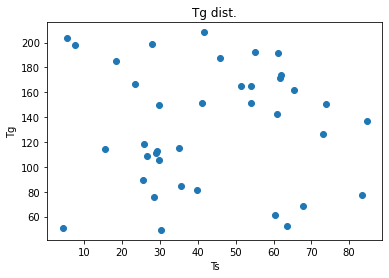

In [10]:
ID = list(range(1,num_sam+1))
plt.scatter (Ts, Tg)
plt.title("Tg dist.")
plt.xlabel("Ts")
plt.ylabel("Tg")

In [11]:
# create a matrix of features
# 1) RD features
HA_Count_RD = np.array(RD_features['HeavyAtomCount'])
HA_Count_RD = HA_Count_RD.reshape((HA_Count_RD.shape[0],1))

HA_Acceptor_RD = np.array(RD_features['NumHAcceptors'])
HA_Acceptor_RD = HA_Acceptor_RD.reshape((HA_Acceptor_RD.shape[0],1))

Num_VA_RD = np.array(RD_features['NumValenceElectrons'])
Num_VA_RD = Num_VA_RD.reshape((Num_VA_RD.shape[0],1))


Num_AromCarboCyc_RD = np.array(RD_features['NumAromaticCarbocycles'])
Num_AromCarboCyc_RD = Num_AromCarboCyc_RD.reshape((Num_AromCarboCyc_RD.shape[0],1))

Unsat_RD = Unsat_RD.reshape((Unsat_RD.shape[0],1))
# 2) Monomor Matrix features
HA_Count_Matrix = np.array(Matrix_features['HeavyAtomCount'])
HA_Count_Matrix = HA_Count_Matrix.reshape((HA_Count_Matrix.shape[0],1))

# 3) considering ratio of matrix/RD
Mat_ratio = np.array(Mat_ratio)
Mat_ratio = Mat_ratio.reshape(Mat_ratio.shape[0],1)
HAMatrix_weighted = np.multiply(HA_Count_Matrix, Mat_ratio)

RD_ratio = np.array(RD_ratio)
RD_ratio = RD_ratio.reshape(RD_ratio.shape[0],1)
HARD_weighted = np.multiply(HA_Count_RD, RD_ratio)

features = np.concatenate((HA_Count_RD, Num_AromCarboCyc_RD,HA_Count_Matrix,
                          HARD_weighted, HAMatrix_weighted), axis=-1)

In [12]:
# Split the data into training and testing sets
rand = randint(1,50)
print(rand)
# Set Random seed if necessary
# Rand seed #8 was used to compile PD data as it performed particularly well
# Random seeds used to compile performance metrics for XGB-R were 8, 9, 22, 29, 42
rand=9
indices = np.arange(len(features))
train_features, test_features, train_Tg, test_Tg, train_Ts, test_Ts, idx_train, idx_test = \
                      train_test_split(features, Tg, Ts, indices, test_size = 0.2, random_state = rand)


9


In [13]:
print (features.shape)
features

(38, 5)


array([[  20,    0,   27,   60,  189],
       [  20,    0,   27,   80,  162],
       [  20,    0,   27,  100,  135],
       [  20,    0,   27,  120,  108],
       [  20,    0,   27,  140,   81],
       [  20,    0,   27,   60,  189],
       [  20,    0,   27,   80,  162],
       [  20,    0,   27,  100,  135],
       [  20,    0,   27,  120,  108],
       [  20,    0,   27,  140,   81],
       [  20,    0,   27,   60,  189],
       [  20,    0,   27,   80,  162],
       [  20,    0,   27,  100,  135],
       [  20,    0,   27,  120,  108],
       [  20,    0,   27,  140,   81],
       [  17,    1,   27,   68,  162],
       [  17,    1,   27,   85,  135],
       [  17,    1,   27,  102,  108],
       [  28,    1,   27,  112,  162],
       [  28,    1,   27,  140,  135],
       [  28,    1,   27,  168,  108],
       [ 247,   10,   27,  988,  162],
       [ 247,   10,   27, 1235,  135],
       [ 247,   10,   27, 1482,  108],
       [  17,    1,   27,   85,  135],
       [  28,    1,   27,

Doneskies


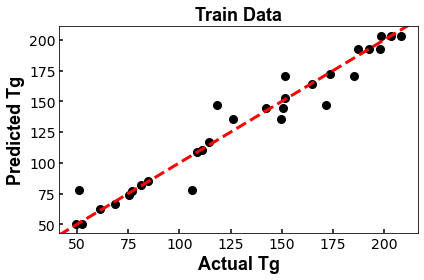

r2 score =  0.9484263403849686
adjusted r2 score=  0.9376818279651704
RMSE =  11.51253770383224
MAE =  6.97464906311035
relative RMSE =  0.2414301720034138


In [14]:
# Instantiate model with 1000 decision trees
# predicting Tg, Training accuracy
XGBR_model = XGBRegressor(max_depth=50, n_estimators=50, gamma=0.01, 
                   learning_rate = 0.4, subsample=0.725, min_child_weight = 2, 
                  random_state=100)
# XGBR_model = linear_model.BayesianRidge()
# XGBR_model = XGBRegressor()
# Train the model on training data
XGBR_model.fit(train_features, train_Tg);
print('Doneskies')

predictions = XGBR_model.predict(train_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(train_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Train Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = train_Tg)
print('r2 score = ', r_squared)
adj_r_squared = 1-(1-r_squared)*(train_Tg.shape[0]-1)/(train_Tg.shape[0]-1-features.shape[1])
print ('adjusted r2 score= ', adj_r_squared)
rmse = math.sqrt(mean_squared_error(y_pred = predictions, y_true = train_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(y_true = train_Tg, y_pred = predictions)
print('MAE = ', mae)
# relative RMSE in the range of [0.2, 0.5] is good
relative_rmse = rmse/np.std(Tg)
print('relative RMSE = ', relative_rmse)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

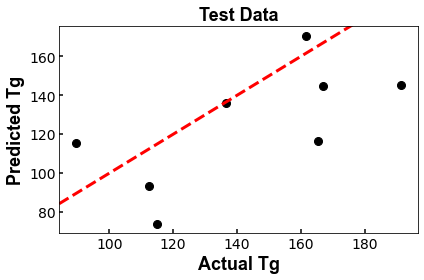

r2 score =  0.06918632831964111
RMSE =  31.28746160579009
MAE =  26.65730411529541


In [15]:
# Instantiate model with 1000 decision trees
# predicting Tg, Testing accuracy
predictions = XGBR_model.predict(test_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(test_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = test_Tg)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(y_pred = predictions, y_true = test_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(y_pred = predictions, y_true = test_Tg)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

Iteration 1, loss = 7918.03324623
Iteration 2, loss = 7373.18245992
Iteration 3, loss = 6894.37608231
Iteration 4, loss = 6479.81177537
Iteration 5, loss = 6128.98516020
Iteration 6, loss = 5840.61661720
Iteration 7, loss = 5611.72586799
Iteration 8, loss = 5438.21054391
Iteration 9, loss = 5314.42620125
Iteration 10, loss = 5232.92159942
Iteration 11, loss = 5184.37111275
Iteration 12, loss = 5158.88887858
Iteration 13, loss = 5147.73290034
Iteration 14, loss = 5142.42937940
Iteration 15, loss = 5136.69201644
Iteration 16, loss = 5126.38971681
Iteration 17, loss = 5108.26562818
Iteration 18, loss = 5080.96907255
Iteration 19, loss = 5044.65521964
Iteration 20, loss = 5000.63768290
Iteration 21, loss = 4950.48228311
Iteration 22, loss = 4895.63907515
Iteration 23, loss = 4838.33710227
Iteration 24, loss = 4780.42249547
Iteration 25, loss = 4724.38398773
Iteration 26, loss = 4671.65212755
Iteration 27, loss = 4623.45027052
Iteration 28, loss = 4579.78195889
Iteration 29, loss = 4539.807

Iteration 320, loss = 996.45808653
Iteration 321, loss = 995.56724075
Iteration 322, loss = 994.62010883
Iteration 323, loss = 993.65570940
Iteration 324, loss = 992.68510980
Iteration 325, loss = 991.70176189
Iteration 326, loss = 990.72423469
Iteration 327, loss = 989.70837756
Iteration 328, loss = 988.69446416
Iteration 329, loss = 987.66965236
Iteration 330, loss = 986.68829049
Iteration 331, loss = 985.72423889
Iteration 332, loss = 984.74307685
Iteration 333, loss = 983.75305516
Iteration 334, loss = 982.75882678
Iteration 335, loss = 981.75482773
Iteration 336, loss = 980.74242134
Iteration 337, loss = 979.72661480
Iteration 338, loss = 978.71761310
Iteration 339, loss = 977.67341325
Iteration 340, loss = 976.59956989
Iteration 341, loss = 975.50926287
Iteration 342, loss = 974.40126169
Iteration 343, loss = 973.27782572
Iteration 344, loss = 972.14408960
Iteration 345, loss = 971.22827317
Iteration 346, loss = 970.29154810
Iteration 347, loss = 969.36203575
Iteration 348, loss 

Iteration 567, loss = 763.25162307
Iteration 568, loss = 762.09652869
Iteration 569, loss = 760.82013134
Iteration 570, loss = 759.34490091
Iteration 571, loss = 757.97061700
Iteration 572, loss = 756.84618746
Iteration 573, loss = 755.79504652
Iteration 574, loss = 754.32716373
Iteration 575, loss = 753.09809126
Iteration 576, loss = 751.97885198
Iteration 577, loss = 750.60990343
Iteration 578, loss = 749.09900333
Iteration 579, loss = 747.57554706
Iteration 580, loss = 746.06034587
Iteration 581, loss = 744.59342277
Iteration 582, loss = 743.04844887
Iteration 583, loss = 741.42379308
Iteration 584, loss = 739.81112481
Iteration 585, loss = 738.26992297
Iteration 586, loss = 736.73880839
Iteration 587, loss = 734.29578529
Iteration 588, loss = 733.41889937
Iteration 589, loss = 731.63461295
Iteration 590, loss = 730.20085196
Iteration 591, loss = 728.22872062
Iteration 592, loss = 725.73121211
Iteration 593, loss = 724.49450774
Iteration 594, loss = 723.14455635
Iteration 595, loss 

Iteration 865, loss = 529.09229527
Iteration 866, loss = 528.54898444
Iteration 867, loss = 527.99054522
Iteration 868, loss = 527.51740135
Iteration 869, loss = 527.06141477
Iteration 870, loss = 526.54265630
Iteration 871, loss = 526.09790334
Iteration 872, loss = 525.62639905
Iteration 873, loss = 525.08712724
Iteration 874, loss = 524.78011530
Iteration 875, loss = 524.24334217
Iteration 876, loss = 523.79043320
Iteration 877, loss = 523.32631511
Iteration 878, loss = 523.01017459
Iteration 879, loss = 522.51896483
Iteration 880, loss = 521.89605681
Iteration 881, loss = 521.58814153
Iteration 882, loss = 521.11516505
Iteration 883, loss = 520.58170883
Iteration 884, loss = 520.21646721
Iteration 885, loss = 519.76600783
Iteration 886, loss = 519.20845427
Iteration 887, loss = 518.72208088
Iteration 888, loss = 518.47197537
Iteration 889, loss = 517.98326829
Iteration 890, loss = 517.16825095
Iteration 891, loss = 516.56634481
Iteration 892, loss = 515.66196853
Iteration 893, loss 

Iteration 1375, loss = 315.24671410
Iteration 1376, loss = 314.78611161
Iteration 1377, loss = 314.53209673
Iteration 1378, loss = 314.15670410
Iteration 1379, loss = 313.79773266
Iteration 1380, loss = 313.40806483
Iteration 1381, loss = 313.43864072
Iteration 1382, loss = 312.88922293
Iteration 1383, loss = 312.52111126
Iteration 1384, loss = 312.24199655
Iteration 1385, loss = 311.99788502
Iteration 1386, loss = 311.57600988
Iteration 1387, loss = 311.28503477
Iteration 1388, loss = 310.84217089
Iteration 1389, loss = 310.60601348
Iteration 1390, loss = 310.18173948
Iteration 1391, loss = 309.88464990
Iteration 1392, loss = 309.57989966
Iteration 1393, loss = 309.34783756
Iteration 1394, loss = 308.98540872
Iteration 1395, loss = 308.64353282
Iteration 1396, loss = 308.25926932
Iteration 1397, loss = 308.03167707
Iteration 1398, loss = 307.54798645
Iteration 1399, loss = 307.42021004
Iteration 1400, loss = 307.02157028
Iteration 1401, loss = 306.84147641
Iteration 1402, loss = 306.4

Iteration 1824, loss = 201.07692118
Iteration 1825, loss = 200.83412763
Iteration 1826, loss = 200.70049475
Iteration 1827, loss = 200.45281853
Iteration 1828, loss = 200.27555224
Iteration 1829, loss = 200.06791048
Iteration 1830, loss = 199.93866856
Iteration 1831, loss = 199.66840982
Iteration 1832, loss = 199.54635030
Iteration 1833, loss = 199.30274490
Iteration 1834, loss = 199.14267020
Iteration 1835, loss = 198.89992716
Iteration 1836, loss = 198.72335716
Iteration 1837, loss = 198.53424308
Iteration 1838, loss = 198.37692905
Iteration 1839, loss = 198.12090349
Iteration 1840, loss = 197.97503651
Iteration 1841, loss = 197.74583522
Iteration 1842, loss = 197.57984184
Iteration 1843, loss = 197.32996284
Iteration 1844, loss = 197.16228496
Iteration 1845, loss = 196.97660642
Iteration 1846, loss = 196.83199520
Iteration 1847, loss = 196.57296033
Iteration 1848, loss = 196.48588196
Iteration 1849, loss = 196.21218683
Iteration 1850, loss = 196.06906326
Iteration 1851, loss = 195.8

Iteration 2060, loss = 158.64778133
Iteration 2061, loss = 158.51704874
Iteration 2062, loss = 158.42546065
Iteration 2063, loss = 158.21754702
Iteration 2064, loss = 157.95414952
Iteration 2065, loss = 157.89452600
Iteration 2066, loss = 157.84269611
Iteration 2067, loss = 157.69691978
Iteration 2068, loss = 157.46415224
Iteration 2069, loss = 157.31227744
Iteration 2070, loss = 157.19503201
Iteration 2071, loss = 157.05976557
Iteration 2072, loss = 156.93320048
Iteration 2073, loss = 156.78423968
Iteration 2074, loss = 156.58270447
Iteration 2075, loss = 156.63364029
Iteration 2076, loss = 156.40815200
Iteration 2077, loss = 156.25272803
Iteration 2078, loss = 156.12608283
Iteration 2079, loss = 155.97665074
Iteration 2080, loss = 155.99764270
Iteration 2081, loss = 155.65926364
Iteration 2082, loss = 155.60431355
Iteration 2083, loss = 155.49400735
Iteration 2084, loss = 155.31732634
Iteration 2085, loss = 155.10603313
Iteration 2086, loss = 154.94596910
Iteration 2087, loss = 154.8

Iteration 2351, loss = 127.26119016
Iteration 2352, loss = 126.99367112
Iteration 2353, loss = 127.08632864
Iteration 2354, loss = 126.81628480
Iteration 2355, loss = 126.86482047
Iteration 2356, loss = 126.61614788
Iteration 2357, loss = 126.59886989
Iteration 2358, loss = 126.49451260
Iteration 2359, loss = 126.51029067
Iteration 2360, loss = 126.39445410
Iteration 2361, loss = 126.30993299
Iteration 2362, loss = 126.17556072
Iteration 2363, loss = 126.13645802
Iteration 2364, loss = 126.06565316
Iteration 2365, loss = 125.98509120
Iteration 2366, loss = 125.81447374
Iteration 2367, loss = 125.79010343
Iteration 2368, loss = 125.71210537
Iteration 2369, loss = 125.64805758
Iteration 2370, loss = 125.57066293
Iteration 2371, loss = 125.48346707
Iteration 2372, loss = 125.37306380
Iteration 2373, loss = 125.28236611
Iteration 2374, loss = 125.27267519
Iteration 2375, loss = 125.18941255
Iteration 2376, loss = 125.13033108
Iteration 2377, loss = 125.00739318
Iteration 2378, loss = 124.9

Iteration 2661, loss = 109.76171624
Iteration 2662, loss = 109.65882391
Iteration 2663, loss = 109.65088146
Iteration 2664, loss = 109.54184791
Iteration 2665, loss = 109.60987204
Iteration 2666, loss = 109.51646689
Iteration 2667, loss = 109.56617104
Iteration 2668, loss = 109.45855587
Iteration 2669, loss = 109.45850119
Iteration 2670, loss = 109.43933348
Iteration 2671, loss = 109.37202102
Iteration 2672, loss = 109.36246154
Iteration 2673, loss = 109.29270889
Iteration 2674, loss = 109.27179756
Iteration 2675, loss = 109.19800562
Iteration 2676, loss = 109.23540202
Iteration 2677, loss = 109.11227605
Iteration 2678, loss = 109.10462581
Iteration 2679, loss = 109.08058836
Iteration 2680, loss = 109.02010459
Iteration 2681, loss = 108.99490665
Iteration 2682, loss = 108.87647527
Iteration 2683, loss = 108.89984598
Iteration 2684, loss = 108.84370155
Iteration 2685, loss = 108.80739897
Iteration 2686, loss = 108.72736759
Iteration 2687, loss = 108.70459726
Iteration 2688, loss = 108.6

Iteration 3140, loss = 97.71854701
Iteration 3141, loss = 97.64096719
Iteration 3142, loss = 97.67053826
Iteration 3143, loss = 97.65893918
Iteration 3144, loss = 97.57756321
Iteration 3145, loss = 97.56466196
Iteration 3146, loss = 97.49319690
Iteration 3147, loss = 97.48052886
Iteration 3148, loss = 97.49356156
Iteration 3149, loss = 97.47217827
Iteration 3150, loss = 97.48281403
Iteration 3151, loss = 97.42469258
Iteration 3152, loss = 97.42122498
Iteration 3153, loss = 97.42516611
Iteration 3154, loss = 97.42330063
Iteration 3155, loss = 97.37061822
Iteration 3156, loss = 97.31511795
Iteration 3157, loss = 97.29413034
Iteration 3158, loss = 97.27247605
Iteration 3159, loss = 97.25291029
Iteration 3160, loss = 97.32416269
Iteration 3161, loss = 97.28393332
Iteration 3162, loss = 97.30458065
Iteration 3163, loss = 97.35649458
Iteration 3164, loss = 97.33031591
Iteration 3165, loss = 97.26684071
Iteration 3166, loss = 97.19868703
Iteration 3167, loss = 97.14850319
Iteration 3168, loss

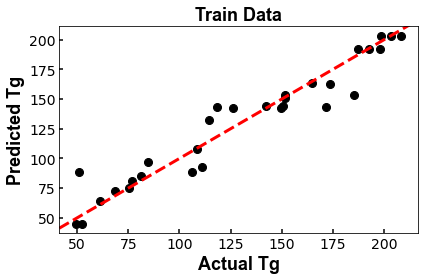

r2 score =  0.9258102425696059
adjusted r2 score=  0.9103540431049404
RMSE =  13.80794556611804
MAE =  9.497757529137177
relative RMSE =  0.289567318587974


In [16]:
mlp_regr = MLPRegressor(random_state=1, max_iter=5000, verbose=1).fit(train_features, train_Tg)

predictions = mlp_regr.predict(train_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(train_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Train Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_true = train_Tg, y_pred=predictions)
print('r2 score = ', r_squared)
adj_r_squared = 1-(1-r_squared)*(train_Tg.shape[0]-1)/(train_Tg.shape[0]-1-features.shape[1])
print ('adjusted r2 score= ', adj_r_squared)
rmse = math.sqrt(mean_squared_error(predictions, train_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(predictions, train_Tg)
print('MAE = ', mae)
# relative RMSE in the range of [0.2, 0.5] is good
relative_rmse = rmse/np.std(Tg)
print('relative RMSE = ', relative_rmse)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

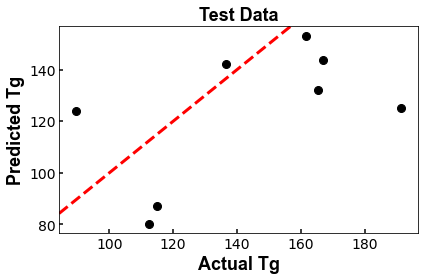

r2 score =  -0.08752508563838557
RMSE =  33.81883124872692
MAE =  28.96084824587002


In [17]:
# Instantiate model with 1000 decision trees
# predicting Tg, Testing accuracy
predictions = mlp_regr.predict(test_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(test_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = test_Tg)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(predictions, test_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(predictions, test_Tg)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

doneskies


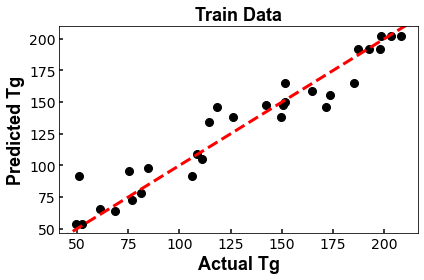

r2 score =  0.9253353683063169
adjusted r2 score=  0.9097802367034663
RMSE =  13.852066069199054
MAE =  10.120160940103373
relative RMSE =  0.29049257250867827


In [18]:
# Instantiate model with 1000 decision trees
RF_regr = RandomForestRegressor(max_depth=5, n_estimators=1000, min_samples_split=3)
# clf = linear_model.BayesianRidge()
# clf = XGBRegressor()
# Train the model on training data
RF_regr.fit(train_features, train_Tg);
print('doneskies')

predictions = RF_regr.predict(train_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(train_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Train Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = train_Tg)
print('r2 score = ', r_squared)
adj_r_squared = 1-(1-r_squared)*(train_Tg.shape[0]-1)/(train_Tg.shape[0]-1-features.shape[1])
print ('adjusted r2 score= ', adj_r_squared)
rmse = math.sqrt(mean_squared_error(y_pred = predictions, y_true = train_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(y_true = train_Tg, y_pred = predictions)
print('MAE = ', mae)
# relative RMSE in the range of [0.2, 0.5] is good
relative_rmse = rmse/np.std(Tg)
print('relative RMSE = ', relative_rmse)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

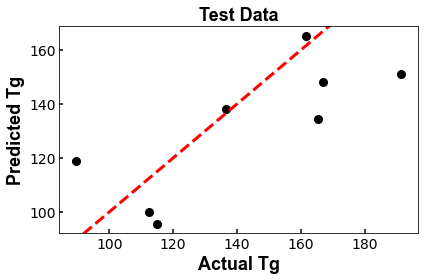

r2 score =  0.4801882396327931
RMSE =  23.380941934520028
MAE =  19.62316218531131


In [19]:
# Instantiate model with 1000 decision trees
# predicting Tg, Testing accuracy
predictions = RF_regr.predict(test_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(test_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = test_Tg)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(predictions, test_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(predictions, test_Tg)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

In [20]:
# creating higher order features (such as Xi^2)
poly = PolynomialFeatures(degree = 1, include_bias=False)
# Instantiate model with 1000 decision trees
lin_regr = linear_model.LinearRegression()
# clf = XGBRegressor()
# Train the model on training data
lin_regr.fit(poly.fit_transform(train_features), train_Tg);
print('doneskies')

predictions = lin_regr.predict(poly.fit_transform(train_features))
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(train_Tg, predictions,  linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Train Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')

# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = train_Tg)
print('r2 score = ', r_squared)
adj_r_squared = 1-(1-r_squared)*(train_Tg.shape[0]-1)/(train_Tg.shape[0]-1-features.shape[1])
print ('adjusted r2 score= ', adj_r_squared)
rmse = math.sqrt(mean_squared_error(y_pred = predictions, y_true = train_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(y_true = train_Tg, y_pred = predictions)
print('MAE = ', mae)
# relative RMSE in the range of [0.2, 0.5] is good
relative_rmse = rmse/np.std(Tg)
print('relative RMSE = ', relative_rmse)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

NameError: name 'poly' is not defined

In [ ]:
# Instantiate model with 1000 decision trees
# predicting Tg, Testing accuracy
predictions = lin_regr.predict(poly.fit_transform(test_features))
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(test_Tg, predictions, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = test_Tg)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(predictions, test_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(predictions, test_Tg)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

In [ ]:
test_Tg

In [ ]:
predictions

In [ ]:
# Instantiate model with 1000 decision trees
lin_Bay_reg = linear_model.BayesianRidge()
# clf = XGBRegressor()
# Train the model on training data
lin_Bay_reg.fit(train_features, train_Tg);
print('doneskies')

predictions = lin_Bay_reg.predict(train_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(train_Tg, predictions, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Train Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = train_Tg)
print('r2 score = ', r_squared)
adj_r_squared = 1-(1-r_squared)*(train_Tg.shape[0]-1)/(train_Tg.shape[0]-1-features.shape[1])
print ('adjusted r2 score= ', adj_r_squared)
rmse = math.sqrt(mean_squared_error(y_pred = predictions, y_true = train_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(y_true = train_Tg, y_pred = predictions)
print('MAE = ', mae)
# relative RMSE in the range of [0.2, 0.5] is good
relative_rmse = rmse/np.std(Tg)
print('relative RMSE = ', relative_rmse)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

In [ ]:
# Instantiate model with 1000 decision trees
# predicting Tg, Testing accuracy
predictions = lin_Bay_reg.predict(test_features)
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

# Predicted Tg
plt.plot(predictions, test_Tg, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Actual Tg', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Predicted Tg', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(y_pred = predictions, y_true = test_Tg)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(predictions, test_Tg))
print('RMSE = ', rmse)
mae = mean_absolute_error(predictions, test_Tg)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)